In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from typing import Union
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import copy

sys.path.append('../')
from src.bioreactor import simulate, \
    MU_MAX, K_S, Y_XS, S_F, X_0, S_0, V_0, T_START, T_END, dt

NUM_EPOCHS = 50000
LEARNING_RATE = 1e-2
NUM_COLLOCATION = 10000
PATIENCE = 100
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1
NUM_SAMPLES = 1000

X_MIN = 0.01
X_MAX = 10.0
S_MIN = 0.10
S_MAX = 20.0
V_MIN = 0.5
V_MAX = 3.0
F_MIN = 0.01
F_MAX = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def generate_dataset(num_samples: int = NUM_SAMPLES):
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'X', 'S', 'V'])
    df['X'] = np.random.uniform(X_MIN, X_MAX, num_samples)
    df['S'] = np.random.uniform(S_MIN, S_MAX, num_samples)
    df['V'] = np.random.uniform(V_MIN, V_MAX, num_samples)
    df['F'] = np.random.uniform(F_MIN, F_MAX, num_samples)
    df['t'] = 0.0 # initial time
    
    t_train = numpy_to_tensor(df['t'].values)
    X_train = numpy_to_tensor(df['X'].values)
    S_train = numpy_to_tensor(df['S'].values)
    V_train = numpy_to_tensor(df['V'].values)
    F_train = numpy_to_tensor(df['F'].values)
    
    in_train = torch.cat([t_train, X_train, S_train, V_train, F_train], dim=1)
    out_train = torch.cat([X_train, S_train, V_train], dim=1)
    
    return in_train, out_train

class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 64)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.output(x)
        return x

In [52]:
def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION))
    X0_col = numpy_to_tensor(np.random.uniform(X_MIN, X_MAX, NUM_COLLOCATION))
    S0_col = numpy_to_tensor(np.random.uniform(S_MIN, S_MAX, NUM_COLLOCATION))
    V0_col = numpy_to_tensor(np.random.uniform(V_MIN, V_MAX, NUM_COLLOCATION))
    F_col = numpy_to_tensor(np.random.uniform(F_MIN, F_MAX, NUM_COLLOCATION))
    
    u_col = torch.cat([t_col, X0_col, S0_col, V0_col, F_col], dim=1)

    preds = net.forward(u_col)

    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    V_pred = preds[:, 2].view(-1, 1)

    dXdt_pred = grad(X_pred, t_col)[0]
    dSdt_pred = grad(S_pred, t_col)[0]
    dVdt_pred = grad(V_pred, t_col)[0]

    mu = MU_MAX * S_pred / (K_S + S_pred)

    error_dXdt = dXdt_pred - mu * X_pred + X_pred * F_col / V0_col
    error_dSdt = dSdt_pred + mu * X_pred / Y_XS - F_col / V0_col * (S_F - S_pred)
    error_dVdt = dVdt_pred - F_col
    
    error_ode = 1/3 * torch.mean(error_dXdt**2) + 1/3 * torch.mean(error_dSdt**2) + 1/3 * torch.mean(error_dVdt**2)

    return error_ode

def main(in_train: torch.Tensor, out_train: torch.Tensor, verbose: int = 100):
    
    net = PINN(input_dim=5, output_dim=3).to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.7)

    # Loss weights
    w_data, w_ode, w_ic = 1.0, 1.0, 1.0

    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD

    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        V_pred = preds[:, 2].view(-1, 1)
        loss_X = nn.MSELoss()(X_pred, out_train[:, 0].view(-1, 1))
        loss_S = nn.MSELoss()(S_pred, out_train[:, 1].view(-1, 1))
        loss_V = nn.MSELoss()(V_pred, out_train[:, 2].view(-1, 1))
        loss_data = 0.33 * (loss_X + loss_S + loss_V)

        loss_ode = loss_fn(net)

        loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % verbose == 0:
            print(f"Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}")
            # Print the current learning rate of the optimizer
            for param_group in optimizer.param_groups:
                print("Current learning rate: ", param_group["lr"])

        if epoch >= EARLY_STOPPING_EPOCH:
            if loss < best_loss - threshold:
                best_loss = loss
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = 1000
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stopping at epoch {epoch}")
                    net.load_state_dict(best_model_weights)
                    break

    return net

In [4]:
in_train, out_train = generate_dataset(num_samples=10000)

In [ ]:
# Check if '../models/pinc_trained.pth' exists
try:
    net = torch.load('../models/pinc_trained.pth')
    print("Model loaded from file")
except FileNotFoundError:
    net = main(in_train, out_train)
    torch.save(net, '../models/pinc_trained.pth')

Model loaded from file


/tmp/ipykernel_2217972/190218288.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('../models/pinc_trained.pth')


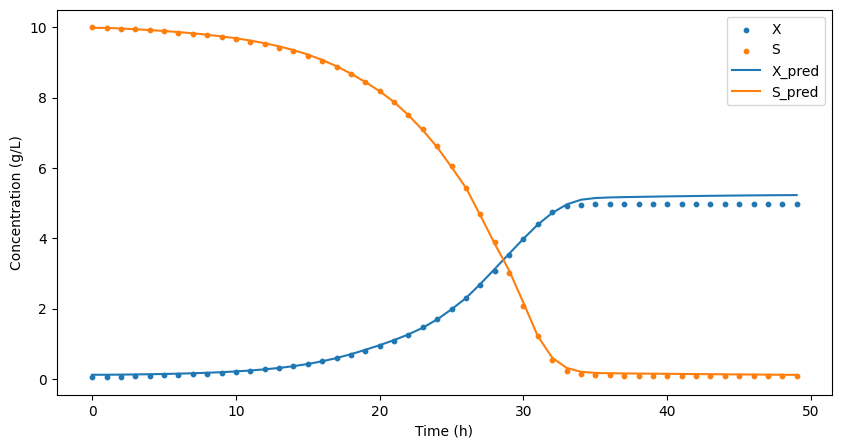

In [6]:
import sys
import pandas as pd
from src.bioreactor import simulate
import torch
import numpy as np
import matplotlib.pyplot as plt

sol = simulate(0.05, plot=False)
sol_df = pd.DataFrame(sol.y.T, columns=['X', 'S', 'V'])
sol_df['t'] = sol.t
sol_df['F'] = 0.05

# Autoregression
T_s = dt
t_test = numpy_to_tensor(np.array([sol_df['t'].values]))
X_test = numpy_to_tensor(np.array([sol_df['X'].values]))
S_test = numpy_to_tensor(np.array([sol_df['S'].values]))
V_test = numpy_to_tensor(np.array([sol_df['V'].values]))
F_test = numpy_to_tensor(np.array([sol_df['F'].values]))

X0 = X_test[0]
S0 = S_test[0]
V0 = V_test[0]
F0 = F_test[0]

X_preds = []
S_preds = []
V_preds = []

for i in range(len(t_test)):
    x_k = net.forward(torch.tensor([T_s, X0, S0, V0, F0], dtype=torch.float32).to(DEVICE))
    X0 = X_test[i]
    S0 = S_test[i]
    V0 = V_test[i]
    F0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())
    V_preds.append(x_k[2].item())
        
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()
V_test = V_test.detach().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.plot(t_test, X_preds, marker='', label="X_pred")
plt.plot(t_test, S_preds, marker='', label="S_pred")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()

In [57]:
sol_df.head()

,X,S,V,t,F
0,0.050000,10.000000,1.00,0,0.05
1,0.057113,9.981012,1.05,1,0.05
2,0.065385,9.960139,1.10,2,0.05
3,0.075018,9.936919,1.15,3,0.05
4,0.086220,9.910890,1.20,4,0.05
